# Homework: Decoding positional information from hippocampal activity

Jezek et al (1) trained a rodent in two environments (square boxes), equal in size and shape, but differing by their light conditions. A population of $L=34$ CA3 place cells was recorded during reference sessions with fixed light conditions, and shown to define environment-specific maps, denoted by A and B. In a subsequent test session, taking place in a single box, instantaneous switches between environmental light conditions are performed and 'teleport' the animal in the other box. This teleportation  trigger the instability of the recalled cognitive map, which flicker back and forth between the two corresponding environments after the ligth switch.

In this notebook, you will train a model to decode the cognitive map from the spiking activity of the place cells in box A and box B. You will then use the model to decode the map in the teleportation test session and to study the flickering behavior.

## Bibliography
1. Posani, Lorenzo, Simona Cocco, and Rémi Monasson. "Integration and multiplexing of positional and contextual information by the hippocampal network." PLoS computational biology 14.8 (2018): e1006320. https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1006320
2. Jezek, Karel, et al. "Theta-paced flickering between place-cell maps in the hippocampus." Nature 478.7368 (2011): 246-249. https://www.nature.com/articles/nature10439

## Data
The data consists of the following files:
1. `cellDataA.mat` contains the spike times of the $L=34$ place cells recorded in environment `A`.
2. `cellDataB.mat` contains the spike times of the $L=34$ place cells recorded in environment `B`.
3. `cellDataD.mat` contain the spike times of the $L=34$ place cells recorded during the teleporting session, when the animal was teleported from environment `A` to `B` and vice versa, several times, starting from environment `A`. The times of the teleportation events are given in `teleportTimes.mat`.

In all the data files, the **time unit** is 1 second.


## Questions

1. Load the data of spiking activities using the code below. Discretize and binarize the spiking events, using discrete time bins of duration 120ms (corresponding to the $\theta$ rythm duration). Thus, for each experiment, you will define a matrix $\mathbf{S} = (S_{ti})$ with $T$ rows corresponding to each time bin, and $L$ columns corresponding to each place cell. $S_{ti}=1$ if the $i$-th place cell spiked at least once in the $t$-th time bin, and $S_{ti}=0$ otherwise. Plot the raster plots of the spiking activity in the two environments, and in the flickering session.

2. Compute the mean activities (probabilities that the cells are active in a time bin) $p_i$ for each place cell $i$, in the two sessions in environments `A` and `B`, and compare them in a scatter plot. What do you observe? Compare the mean activities in the teleportation session with the mean activities in sessions `A`, and `B`. What do you observe?

3. You will construct two Maximum Entropy models, $P_A(\mathbf s_t)$ and $P_B(\mathbf s_t)$, of the spiking activities in the two environments, where $\mathbf s_t = (S_{t1},\dots,S_{tL})$ is the vector of spiking activities of the $L$ neurons in the $t$-th time bin. Write down the likelihood function of the models $P_A(\mathbf s_t)$ and $P_B(\mathbf s_t)$, which maximize the entropy subject to matching the average neuron activities in the corresponding environments.

4. Compute the parameters of the Maximum Entropy models, as a function of the average spiking rates of the neurons in the two datasets. Since some of the neurons may have vanishingly small spiking rates, add a pseudo-count on the mean activities: $p_i'=(1-\alpha)p_i+\alpha$, before computing the parameters of your model. Use $\alpha=0.0002$ in both cases ($\sim$ the inverse of the number of time bins).

5. Plot the log-likelihoods $\ln P_A(\mathbf s_t)$ and $\ln P_B(\mathbf s_t)$ as function of time, for the datasets in environments `A` and `B`. What do you observe?

6. Given a spiking activity pattern, $\mathbf s_t$, we would like to decode the environment of the roedent. Use Bayes theorem to compute the posterior probability of environments $A$ and $B$, given the spiking activity pattern $\mathbf s_t$. 

BONUS: Assuming uniform priors $P(A) = P(B) = 1/2$, show that the posterior $P(A|\mathbf s_t)$ can be expressed as a function of the log-likelihood difference, $\Delta L(\mathbf s_t) = \ln P_A(\mathbf s_t) - \ln P_B(\mathbf s_t)$.

7. To decode the environment from the spiking patterns, we use the log-likelihood differences $\Delta L(\mathbf s_t) = \ln P_A(\mathbf s_t) - \ln P_B(\mathbf s_t)$. Plot the two histograms of $\Delta L(\mathbf s_t)$, for the activity recorded in environment A, and in environment B. Discuss.

8. Decode, at each time bin, the environment for the activity recorded in environment `A`, and compute the decoding error as the percentage of time bins in which you decode as most likely the model corresponding to environment `B`. Compute similarly the decoding error of decoding environment `A` from the activity recorded on environment `B`. These are the 'train' decoding errors, as they are computed on the sessions used to train your models.

9. Repeat the analysis for the flickering test sessions. Plot $\Delta L(\mathbf s_t)$ as function of time, for the datasets in the teleportation experiments. Highlight the teleportation times given i `teleportTimes.mat` in the plot. How does your inference reflect the teleportation events? To make the trend more evident, you can repeat the plot of $\Delta L(\mathbf s_t)$ as function of time, but this time smoothed over a sliding window of 100 bins. Finally, compare the histograms of $\Delta L(\mathbf s_t)$, at times $t$ where the animal is in environment `A`, vs. the histogram at times $t$ where the animal is in environment `B`.

10. Knowing that the teleportation experiment starts in environment 'A', and then the animal is teleported between the two environments at the times given in `teleportTimes.mat`, locate the time bins where the map *flickers*, after a teleportation i.e. where your model oscillates between decoding the good and wrong environment. Plot the fraction of errors in sliding windows of 100 time bins, as a function of time, and highligt the times of the teleportation events. Discuss how flickering is correlated with the teleportation events and interpret these results.
Finally, repeat the plot focusing on the first 500 time bins (around the first teleportation event). What can you say about the duration of the flicker?

In [1]:
import scipy
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

### Question 1

Load the data of spiking activities using the code below. Discretize and binarize the spiking events, using discrete time bins of duration 120ms (corresponding to the $\theta$ rythm duration). Thus, for each experiment, you will define a matrix $\mathbf{S} = (S_{ti})$ with $T$ rows corresponding to each time bin, and $L$ columns corresponding to each place cell. $S_{ti}=1$ if the $i$-th place cell spiked at least once in the $t$-th time bin, and $S_{ti}=0$ otherwise. Plot the raster plots of the spiking activity in the two environments, and in the flickering session.

In [2]:
# Number of neurons
L = 34

# Spiking times
datasA = scipy.io.loadmat('data/cellDataA.mat', matlab_compatible=True)['cellDataA'][0] # environment A
datasB = scipy.io.loadmat('data/cellDataB.mat', matlab_compatible=True)['cellDataB'][0] # environment B
datasD = scipy.io.loadmat('data/cellDataD.mat', matlab_compatible=True)['cellDataD'][0] # teleportation sessions

# Teleport times
teleportTimes = scipy.io.loadmat('data/teleportTimes.mat', matlab_compatible=True)['teleportTimes']

In [3]:
#Function to binarise the data

def binarise_data(data, dt=0.12, L=34):
    #Find minimum and maximimum
    T_min = min(np.min(neuron) for neuron in data)
    T_max = max(np.max(neuron) for neuron in data)
    S = np.zeros((((T_max-T_min) / dt).astype(int) + 1, L), dtype=int)
    for i, t in enumerate (data):
        S[((t-T_min) // dt).astype(int), i] =1
    return S


In [4]:
#Apply binarise_data function to spiking times

S_datasA=binarise_data(datasA)
S_datasB=binarise_data(datasB)
S_datasD=binarise_data(datasD)

#Check data shape
print(S_datasA.shape)
print(S_datasB.shape)
print(S_datasD.shape)



(5145, 34)
(7181, 34)
(6559, 34)


In [5]:
#Plot the raster plots 

#redo raster plot better if time

def raster_plot (S, title):
    n_neurons = S.shape[1]
    n_timebins = S.shape[0]
    dt=0.12
    
    plt.figure(figsize=(10,6))
    
    for i in range (n_neurons):
        spikes = [t/dt for t in range(n_timebins) if S[t, i]>0]
        plt.eventplot(spikes, colors='blue', linelength=0.3, lineoffsets=i)
    
    plt.xlabel ('Time-bins')
    plt.ylabel ('Neuron')
    plt.yticks (range(n_neurons), range(1, n_neurons + 1))
    plt.title(f'Raster plot {title}')
    plt.show
    

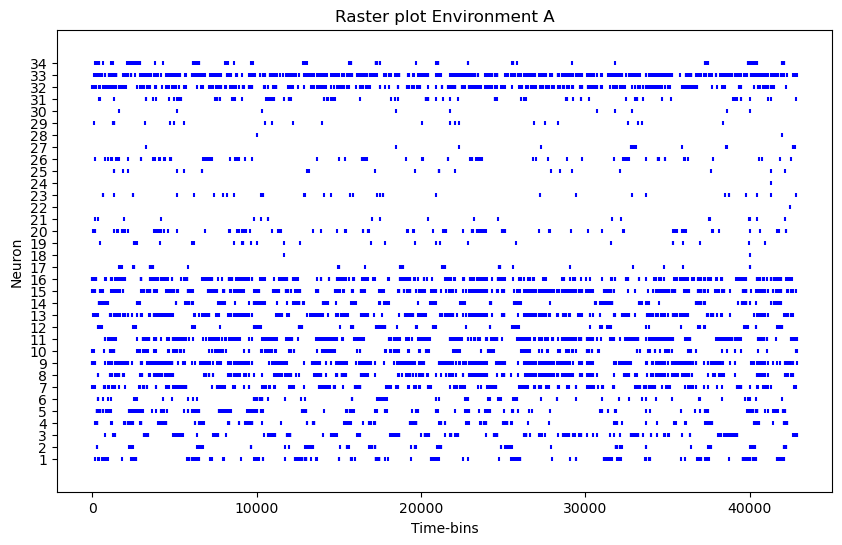

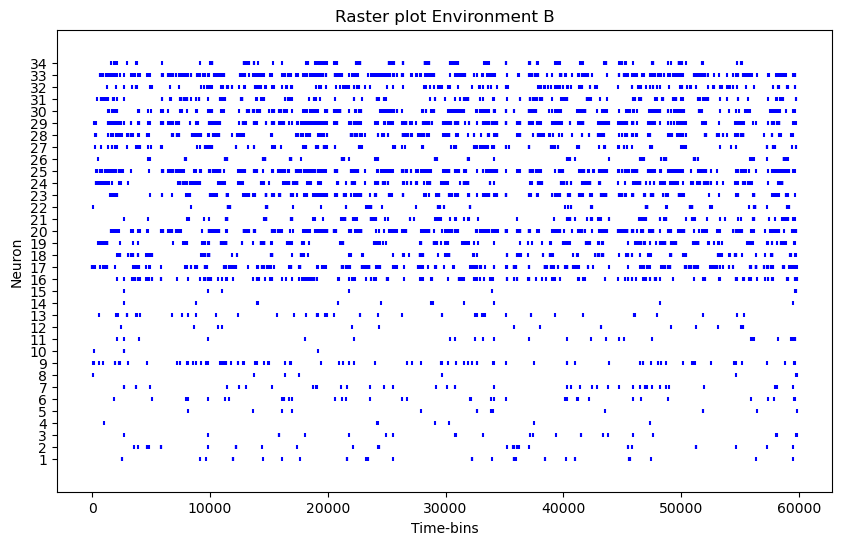

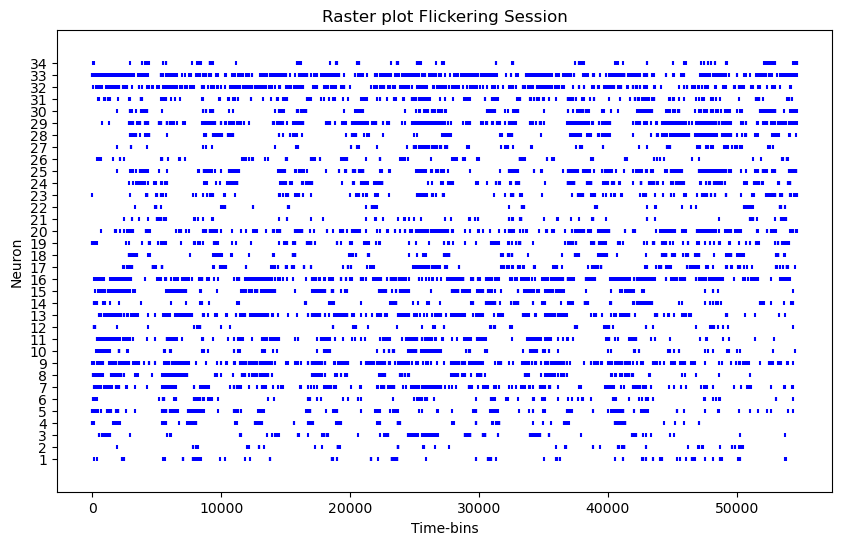

In [6]:
#Print raster plots 

raster_plot(S_datasA,'Environment A')    

raster_plot(S_datasB, 'Environment B')  

raster_plot(S_datasD, 'Flickering Session')  


### Question 2

Compute the mean activities (probabilities that the cells are active in a time bin) $p_i$ for each place cell $i$, in the two sessions in environments `A` and `B`, and compare them in a scatter plot. What do you observe? Compare the mean activities in the teleportation session with the mean activities in sessions `A`, and `B`. What do you observe?


In [7]:
#Define the probability
def probability (S):
    prob=np.mean(S, axis=0)
    return prob

In [8]:
#Calculate the empirical probability of spiking per environment

prob_datasA = probability(S_datasA)
prob_datasB = probability(S_datasB)
prob_datasD = probability(S_datasD)

In [9]:
#Create scatter plot


def scatter_plot(ax, prob_1, prob_2, title, x_label, y_label):
    ax.scatter(prob_1, prob_2)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)



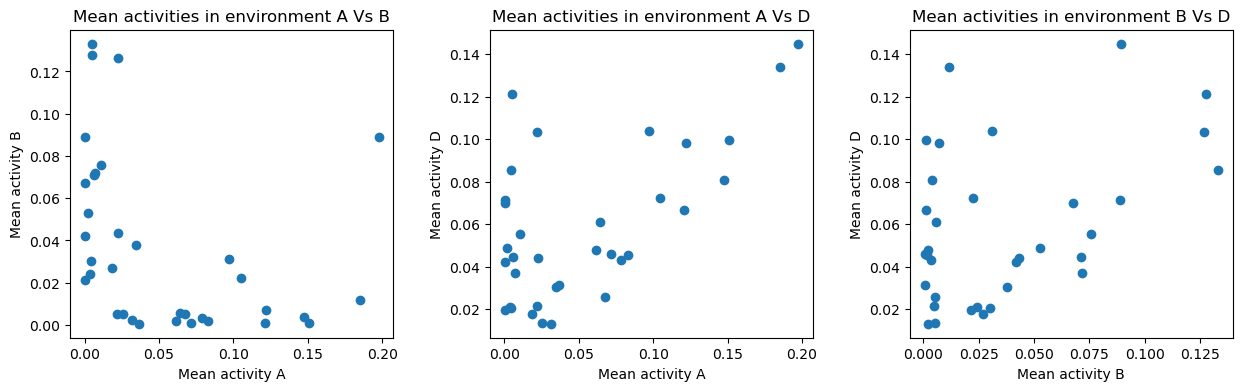

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))  # 1 row, 3 columns for subplots
plt.subplots_adjust(wspace=0.3) 
scatter_plot(ax1, prob_datasA, prob_datasB, 'Mean activities in environment A Vs B', 'Mean activity A', 'Mean activity B')
scatter_plot(ax2, prob_datasA, prob_datasD, 'Mean activities in environment A Vs D', 'Mean activity A', 'Mean activity D')
scatter_plot(ax3, prob_datasB, prob_datasD, 'Mean activities in environment B Vs D', 'Mean activity B', 'Mean activity D')

- From the first scatter plot comparing the mean activities in environment A and B we can observe datapoints seem to have an inverse non-linear relationship. The plot suggests that when the mean activity rises in one of the environment it decreases drastically in the other environment, indicating that place cells spiking for environment A are not the same as those spiking for environment B.

<br>

- When comparing the activity in environment A (graph 2) and B (graph 3) to the flickering session D we can observe a partial linear relationship in both cases, suggesting that there is a correlation between the activity recorded in each environment and that recorded in D. This correlation is to be anticipated, considering that the flickering session equally involved activities from both environments - half in environment A and the other half in environment B. 

### Question 3

You will construct two Maximum Entropy models, $P_A(\mathbf s_t)$ and $P_B(\mathbf s_t)$, of the spiking activities in the two environments, where $\mathbf s_t = (S_{t1},\dots,S_{tL})$ is the vector of spiking activities of the $L$ neurons in the $t$-th time bin. Write down the likelihood function of the models $P_A(\mathbf s_t)$ and $P_B(\mathbf s_t)$, which maximize the entropy subject to matching the average neuron activities in the corresponding environments.

### Likelihood Function Mathematical Background

Probability of one neuron to spike $S_{i}$ in environemnt is given by $P(s_i)$:

<br>

\begin{equation*}
p(s_{i}) = \frac{e^{hi si}}{1+e^{hi}}
\end{equation*}

<br>

- Where the probability of a neuron being active is given by $P_{i}$ and that of being inactive is $1-P_{i}$
    
    \begin{equation*}
    p(s_{i} = 1) = p_{i}
    \end{equation*}
    
    \begin{equation*}
    p(s_{i} = o) = 1- p_{i}
    \end{equation*}
    
    As such, hi is given by:
    
    \begin{equation*}
    h_i = \log{\frac{p_i}{1-p_i}}
    \end{equation*}

<br>


The independent probability of L neurons being active in an environment is given by $P(s)$:

<br>

\begin{equation*}
P(s_{1}, s_{2},...,s_{L}) = \prod_{i=1}^{L}\ p(s_{i})
\end{equation*}

<br>

\begin{equation*}
P(s) = \frac{\prod_{i=1}^{L} e^{h_i s_i}}{\prod_{i=1}^{L} 1 + e^{h_i}}
\end{equation*}

<br>

Due to the exponent rule with the same base: $e^{a} \times e^{b} = e^{a+b}$, the likelihood is:

<br>

\begin{equation*}
P(s) = \frac{e\sum{hi si}}{\prod_{i=1}^{L} 1 + e^{h_i}}
\end{equation*}


Transform in logarithm:

<br>

\begin{equation*}
log(P(s)) = \log{\frac{e\sum{hi si}}{\prod_{i=1}^{L} 1 + e^{h_i}}}
\end{equation*}

<br>

Due to the logarithm rule with the same base: $log_{a}{M x N} = log_{a}{M} + log_{a}{N}$, the log-likelihood is:

<br> 

\begin{equation*}
log(P(s)) = \sum{hi si} - \sum{\log{1+e^{hi}}}
\end{equation*}


In [11]:
#Define parameters

def hi_parameter (prob_datas):
    hi = np.log(prob_datas / (1 - prob_datas))
    return hi


#Define log-likelihood

def log_likelihood (prob_datas, s_datas):
    
    hi = np.log(prob_datas / (1 - prob_datas))
    si = s_datas

    log_likelihood = np.sum(hi * si, axis=1) - np.sum(np.log(1 + np.exp(hi)))
    return log_likelihood


### Question 4

Compute the parameters of the Maximum Entropy models, as a function of the average spiking rates of the neurons in the two datasets. Since some of the neurons may have vanishingly small spiking rates, add a pseudo-count on the mean activities: $p_i'=(1-\alpha)p_i+\alpha$, before computing the parameters of your model. Use $\alpha=0.0002$ in both cases ($\sim$ the inverse of the number of time bins).

In [12]:
#Integrate pseudo-count with calculated probabilities

a=0.0002
p_i_A = (1-a)*prob_datasA + a
p_i_B = (1-a)*prob_datasB + a


#Compute parameters hi for each environment

hi_stA_A = hi_parameter(p_i_A)
hi_stB_B = hi_parameter(p_i_B)




#Compute log-likelihoods with the pseudo_counted probabilities

log_likelihood_stA_A = log_likelihood(p_i_A,S_datasA)
log_likelihood_stA_B = log_likelihood(p_i_B,S_datasA)
log_likelihood_stB_B = log_likelihood(p_i_B,S_datasB)
log_likelihood_stB_A = log_likelihood(p_i_A,S_datasB)


#Compute the likelihoods with 


likelihood_stA_A = np.exp(log_likelihood(p_i_A,S_datasA))
likelihood_stA_B = np.exp(log_likelihood(p_i_B,S_datasA))
likelihood_stB_B = np.exp(log_likelihood(p_i_B,S_datasB))
likelihood_stB_A = np.exp(log_likelihood(p_i_A,S_datasB))


In [13]:
log_likelihood_stA_A

array([ -7.36413102, -13.71604853, -10.89048964, ..., -10.801266  ,
        -3.41043727,  -6.13894012])

### Question 5

Plot the log-likelihoods $\ln P_A(\mathbf s_t)$ and $\ln P_B(\mathbf s_t)$ as function of time, for the datasets in environments `A` and `B`. What do you observe?

In [14]:
#Create a function for the log likelihood plots


def log_likelihoods_plot(ax, log_1, log_2, title, x_label, y_label, color1, label1, color2, label2):
    ax.plot(range(len(log_1)), log_2, color=color1, label=label1)
    ax.plot(range(len(log_1)), log_1, color=color2, label=label2)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.legend()
    ax.set_title(title)


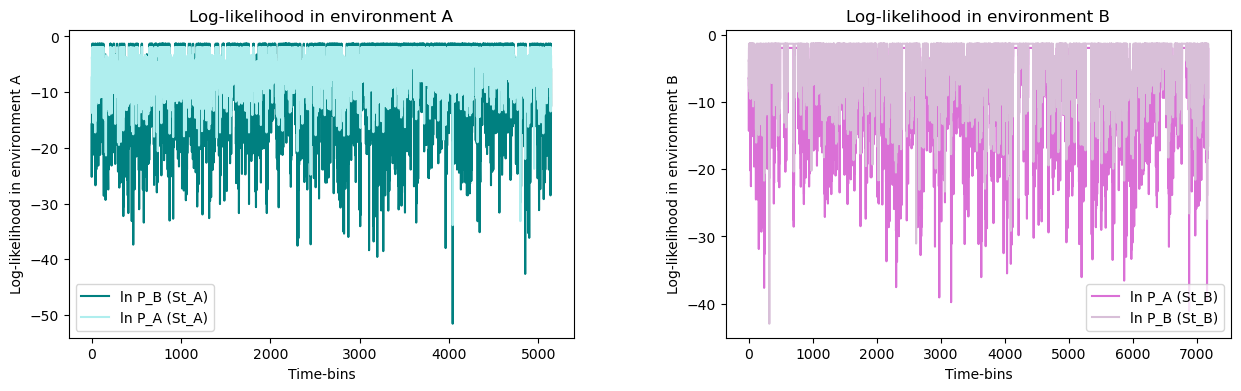

In [15]:
#Display the log likelihood plots for each environment

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))  # 1 row, 2 columns for subplots
plt.subplots_adjust(wspace=0.3) 

# Plot comparing the likelihoods P_A(St_A) and P_B(St_A) of the two Max Entropy models for the spikes recorded in environment A (St_A)

log_likelihoods_plot(ax1, log_likelihood_stA_A, log_likelihood_stA_B, 'Log-likelihood in environment A', 'Time-bins', 'Log-likelihood in environment A', 'teal', 'ln P_B (St_A)', 'paleturquoise', 'ln P_A (St_A)')


# Plot comparing the likelihoods P_B(St_B) and P_A(St_B) of the two Max Entropy models for the spikes recorded in environment B (St_B)

log_likelihoods_plot(ax2, log_likelihood_stB_B, log_likelihood_stB_A, 'Log-likelihood in environment B', 'Time-bins', 'Log-likelihood in environment B', 'orchid', 'ln P_A (St_B)', 'thistle', 'ln P_B (St_B)')


- The two plots displayed above compare the likelihoods $ln P_{A}$ and $ln P_{B}$ of each Max Entropy model for the spiking activity  $S_{t_A}$ and $S_{t_B}$ recorded from each environemnt A and B respectively.

<br>

- As expected, the likelihoods built from empirical data seem to explain better the data they were derived from. For example, in the first graph $ln P_{A} (St_{A})$ presents higher likelihood values than $ln P_{B} (St_{A})$ in environment A. Similarly, in the second graph we can observe that $ln P_{B} (St_{B})$ has greater values than $ln P_{A} (St_{B})$.

### Question 6

Given a spiking activity pattern, $\mathbf s_t$, we would like to decode the environment of the roedent. Use Bayes theorem to compute the posterior probability of environments $A$ and $B$, given the spiking activity pattern $\mathbf s_t$. 

According to Bayes Theorem, we have that the posterior probability $P(A|St)$ is given by:

\begin{equation*}
P(A|St) = \frac{P(St|A)P(A)}{P(St)}
\end{equation*}

<br>

However, the probability of spikes $P(St)$ is given by:  $P(St) = P(St|A) P(A) + P(St|B) P(B)$

<br>

Thus:

\begin{equation*}
P(A|St) = \frac{P(St|A) P(A)}{P(St|A) P(A) + P(St|B) P(B)}
\end{equation*}

<br>

Assuming a uniform prior where $P(A)$ = $P(B)$, we have:

<br>

\begin{equation*}
P(A|St) = \frac{P(St|A) P(A)}{P(A)(P(St|A) + P(St|B)}
\end{equation*}

<br>

\begin{equation*}
P(A|St) = \frac{P(St|A)}{(P(St|A) + P(St|B))}
\end{equation*}

<br>

\begin{equation*}
P(A|St) = \frac{1}{1 + \frac{P(St|B)}{P(St|A)}}
\end{equation*}

<br>

In the context of this experiment:

<br>


$P(A|St_A)$ is given by:

\begin{equation*}
P(A|St_A) = \frac{1}{1 + \frac{P(St_A|B)}{P(St_A|A)}}
\end{equation*}


$P(B|St_A)$ is given by:


\begin{equation*}
P(B|St_A) = \frac{1}{1 + \frac{P(St_A|A)}{P(St_A|B)}}
\end{equation*}


$P(B|St_B)$ is given by:

\begin{equation*}
P(B|St_B) = \frac{1}{1 + \frac{P(St_B|A)}{P(St_B|B)}}
\end{equation*}



$P(A|St_B)$ is given by:

\begin{equation*}
P(A|St_B) = \frac{1}{1 + \frac{P(St_B|B)}{P(St_B|A)}}
\end{equation*}


In [16]:
#Define posterior probability

def posterior (likelihood_1, likelihood_2):
    posterior = 1 / (1+(likelihood_1/likelihood_2))
    return posterior

In [17]:
#Posterior probabilities for spikes recorded in environment A

posterior_A_stA = posterior(likelihood_stA_B,likelihood_stA_A)
posterior_B_stA = posterior(likelihood_stA_A,likelihood_stA_B)


#Posterior probabilities for spikes recorded in environment B

posterior_A_stB = posterior(likelihood_stB_B,likelihood_stB_A)
posterior_B_stB = posterior(likelihood_stB_A,likelihood_stB_B)


#### BONUS: 

Assuming uniform priors $P(A) = P(B) = 1/2$, show that the posterior $P(A|\mathbf s_t)$ can be expressed as a function of the log-likelihood difference, $\Delta L(\mathbf s_t) = \ln P_A(\mathbf s_t) - \ln P_B(\mathbf s_t)$.

Assuming that the log-likelihood difference $\Delta L(S_{t})$ is given by:

<br>

\begin{equation*}
\Delta L(S_{t}) = \ln P_{A}S_{t} - \ln P_{B}S_{t}
\end{equation*}

<br>

Then the exponential form of such difference is:

\begin{equation*}
e^{\Delta L(S_{t})} = \frac{P(St|A)}{P(St|B)}
\end{equation*}

<br>

However, as demonstrated previously:

\begin{equation*}
P(A|St) = \frac{1}{1 + \frac{P(St|B)}{P(St|A)}}
\end{equation*}

<br>

Thus, the negative of the exponent log-likelihood difference $\Delta L(S_{t})$:

\begin{equation*}
e^{-\Delta L(S_{t})} = \frac{P(St|B)}{P(St|A)}
\end{equation*}

<br>

Therefore the posterior probability $P(St_A|A)$ can be expressed as a function of: 

\begin{equation*}
P(A|St) = \frac{1}{1 + e^{-\Delta L(S_{t})}}
\end{equation*}



In [18]:
#Define posterior by using Delta_L

def posterior_2 (log_likelihood_1, log_likelihood_2):
    posterior_2= 1/(1+(np.exp(-(log_likelihood_1-log_likelihood_2))))
    return posterior_2


In [19]:
#Calculate Delta_L for each environment

#Environment A
delta_L_stA= log_likelihood_stA_A-log_likelihood_stA_B

#Environemnt B
delta_L_stB= log_likelihood_stB_A-log_likelihood_stB_B




### Question 7

To decode the environment from the spiking patterns, we use the log-likelihood differences $\Delta L(\mathbf s_t) = \ln P_A(\mathbf s_t) - \ln P_B(\mathbf s_t)$. Plot the two histograms of $\Delta L(\mathbf s_t)$, for the activity recorded in environment A, and in environment B. Discuss.


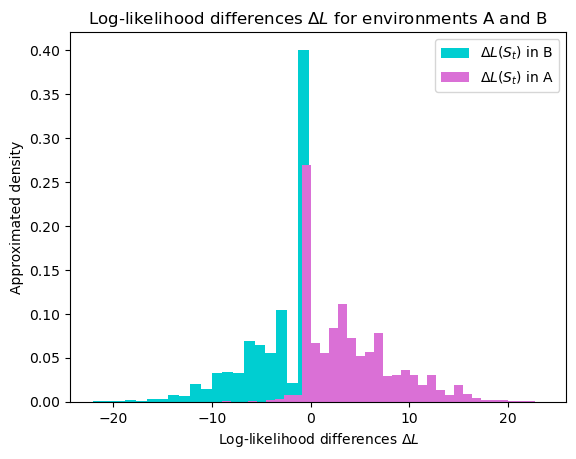

In [20]:
#Plot log-likelihood differences histograms

plt.hist(delta_L_stB, bins = 40, color='darkturquoise', density=True, label='$\Delta L (S_{t})$ in B')
plt.hist(delta_L_stA, bins = 40, color='orchid', density=True, label='$\Delta L (S_{t})$ in A')
plt.xlabel('Log-likelihood differences $\Delta L$')
plt.ylabel('Approximated density')
plt.legend()
plt.title('Log-likelihood differences $\Delta L$ for environments A and B')
plt.show()



- The graph above shows the log-likelihood differences $\Delta L (S_{t})$ for environments A and B. As we can observe, the two histograms of the $\Delta L (S_{t})$ display different frequency for each environment. Indeed, $\Delta L (S_{t})$ A (shown in pink) is skewed to the right of the graph while $\Delta L (S_{t})$ B (shown in turquoise) density is distributed on the left of the graph. Given that $\Delta L(S_{t}) =  \ln {P_{A}S_{t}} - \ln {P_{B}S_{t}}$, intuiively the graph suggests that environment A is more likely to be the correct one for the spiking recorded in A, while environment B is more likely for the spiking recorded in B. 

<br>

- Nevertheless, in the middle of the graph, we can observe a peak in the frequency for both log-likelihood differences $\Delta L (S_{t})$ around the value 0. This suggests that in nearly half of the time-bins both environments are as likely to explain the spiking data.



### Question 8

Decode, at each time bin, the environment for the activity recorded in environment `A`, and compute the decoding error as the percentage of time bins in which you decode as most likely the model corresponding to environment `B`. Compute similarly the decoding error of decoding environment `A` from the activity recorded on environment `B`. These are the 'train' decoding errors, as they are computed on the sessions used to train your models.


In [21]:
#Posterior given spikes in A
posterior_A_stA_2=posterior_2(log_likelihood_stA_A, log_likelihood_stA_B)
posterior_B_stA_2=posterior_2(log_likelihood_stA_B, log_likelihood_stA_A)


#Posterior given spikes in B
posterior_B_stB_2=posterior_2(log_likelihood_stB_B, log_likelihood_stB_A)
posterior_A_stB_2=posterior_2(log_likelihood_stB_A, log_likelihood_stB_B)





In [22]:
#Probability of missclasification is given by the amount of time the spiking data is explained by the wrong model

def missassigned_posterior(posterior_1, posterior_2):
    result = [1 if p1 < p2 else 0 for p1, p2 in zip(posterior_1, posterior_2)]
    return result


#Error rate is given by the sum of misclassed time bins divided by the total amount of timebins

def error_rate (posterior_1, posterior_2):
    error_rate = (np.sum(missassigned_posterior(posterior_1,posterior_2))/len(posterior_1))*100
    return error_rate



In [23]:
#Calculate error rates per environment

#Environment A
error_rate_A = error_rate(posterior_A_stA_2, posterior_B_stA_2)
print(error_rate_A)


#Environment B
error_rate_B = error_rate(posterior_B_stB_2, posterior_A_stB_2)
print(error_rate_B)

26.375121477162295
4.316947500348141


- The decoding error rate for environment A is 26.4% while the one for environment B is 4.3%.

### Question 9

Repeat the analysis for the flickering test sessions. Plot $\Delta L(\mathbf s_t)$ as function of time, for the datasets in the teleportation experiments. Highlight the teleportation times given i `teleportTimes.mat` in the plot. How does your inference reflect the teleportation events? To make the trend more evident, you can repeat the plot of $\Delta L(\mathbf s_t)$ as function of time, but this time smoothed over a sliding window of 100 bins. Finally, compare the histograms of $\Delta L(\mathbf s_t)$, at times $t$ where the animal is in environment `A`, vs. the histogram at times $t$ where the animal is in environment `B`.

In [24]:
#Log likelihoods flickering session

#Calculate pseudo-probability for flickering session
p_i_D = (1-a)*prob_datasD + a


#Calculate log-likelihoods of spicking data in flickering session for each potential model

#log_likelihood_stD_D = log_likelihood(p_i_D,S_datasD)
log_likelihood_stD_A = log_likelihood(p_i_A,S_datasD)
log_likelihood_stD_B = log_likelihood(p_i_B,S_datasD)


In [25]:
#Calculate delta likelihoods of spiking of D

delta_L_D = log_likelihood_stD_A - log_likelihood_stD_B

dt=0.12
t_D = np.arange(0,S_datasD.shape[0]*dt, dt)


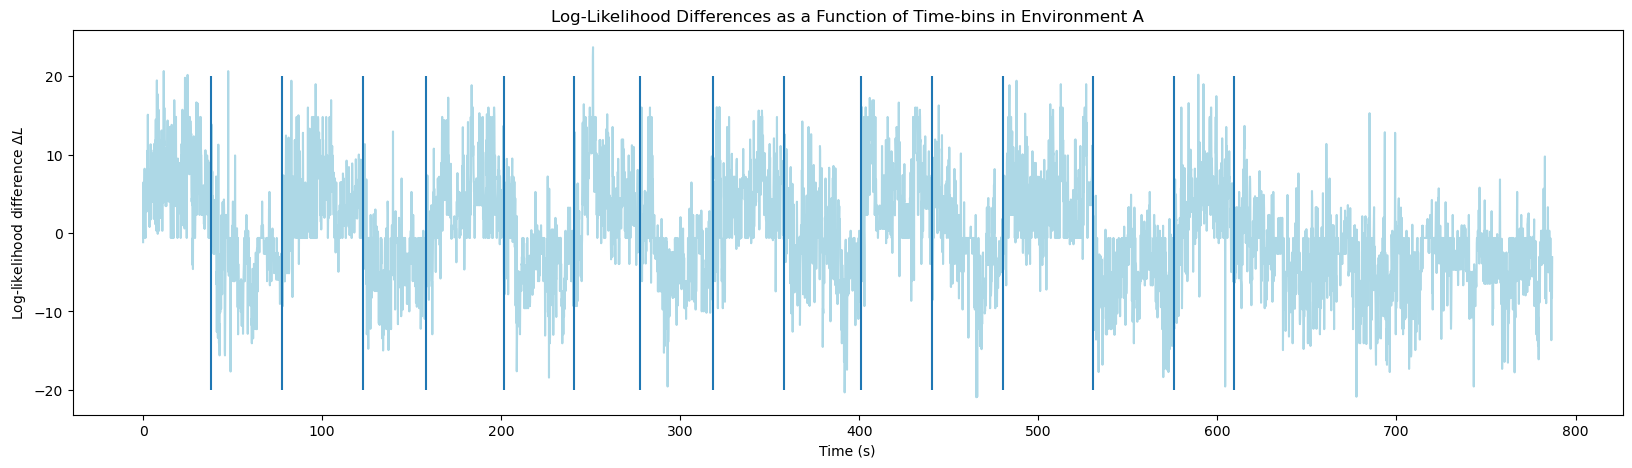

In [26]:
#Plot the log_likelihood difference with teleportation events as a function of time-bins

plt.figure(figsize=(20,5))
plt.plot(t_D, delta_L_D, color='lightblue')
plt.xlabel('Time (s)')
plt.vlines(teleportTimes, ymin=-20, ymax=20)
plt.ylabel('Log-likelihood difference $\Delta L$ ')
plt.title('Log-Likelihood Differences as a Function of Time-bins in Environment A')
plt.show()


- From the graph above, we can observe that the produced inference closely mirrors the teleportation events. The transition from positive to negative log-likelihood differences after each teleportation indicates a shift in the environment, to which a distinct model responds more effectively.

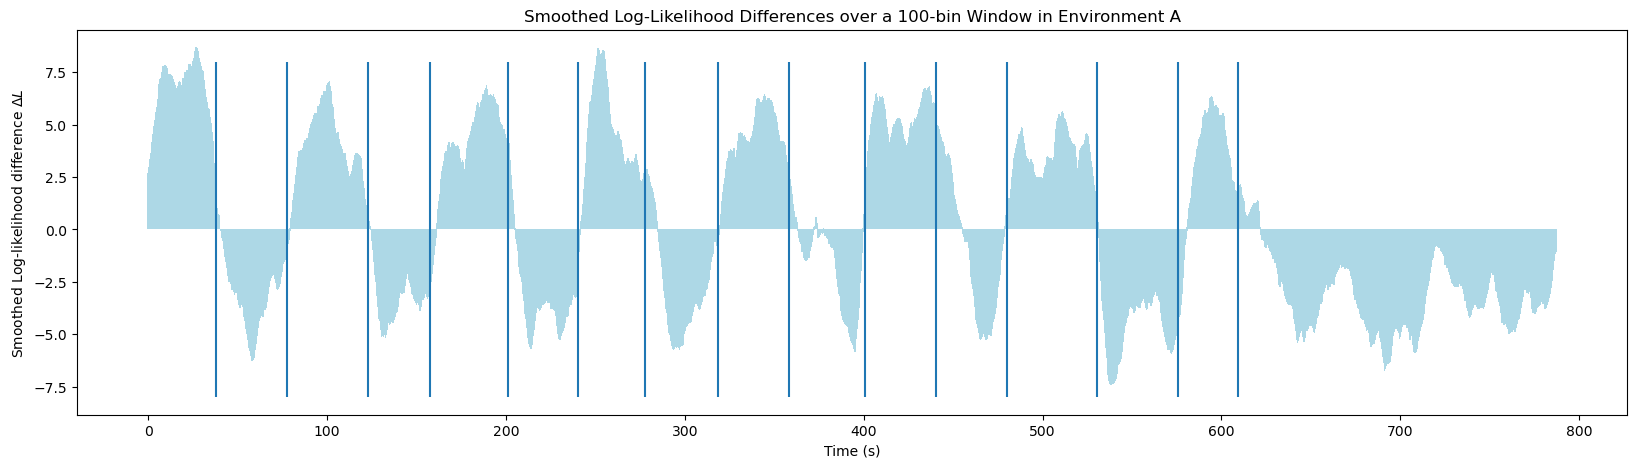

In [27]:
#Smoothed plot over 100 time bins, check axis x

window_size = 100
smoothed_delta_L_D = np.convolve(delta_L_D, np.ones(window_size)/window_size, mode='same')

plt.figure(figsize=(20,5))
plt.bar(t_D, smoothed_delta_L_D, color='lightblue')
plt.xlabel('Time (s)')
plt.vlines(teleportTimes, ymin=-8, ymax=8)
plt.ylabel('Smoothed Log-likelihood difference $\Delta L$ ')
plt.title('Smoothed Log-Likelihood Differences over a 100-bin Window in Environment A')
plt.show()


#CHECK TIME UNIT

In [28]:
#Create boolean array depending on teleportTimes

transition_type = ["A to B" if i % 2 == 0 else "B to A" for i in range(len(teleportTimes))]

bol_A = np.zeros(len(t_D))
bol_B = np.zeros(len(t_D))

# Find indices for IsA and IsB based on teleportTimes and transition_type
for idx, (start, end, tp_type) in enumerate(zip(teleportTimes, teleportTimes[1:], transition_type)):
    if tp_type == "B to A":
        bol_A[(t_D > start) & (t_D < end)] = 1
    elif tp_type == "A to B":
        bol_B[(t_D > start) & (t_D < end)] = 1

# Set IsA or IsB based on the last teleportType
if transition_type[-1] == "B to A":
    bol_A[t_D > teleportTimes[-1]] = 1
elif transition_type[-1]=="A to B":
    bol_B[t_D > teleportTimes[-1]] = 1


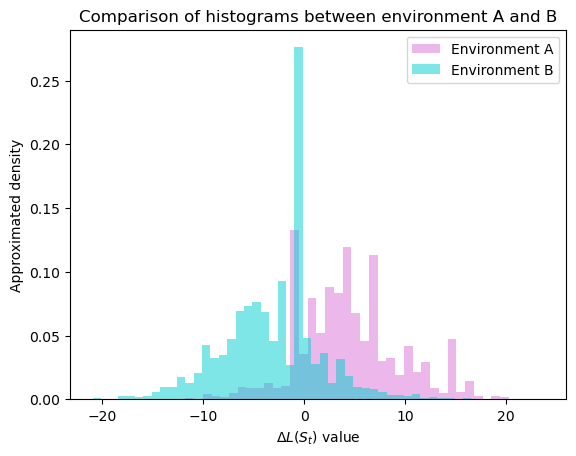

In [29]:
#Separate data from delta_L_D based on bolean arrays

data_A = delta_L_D[bol_A == 1]
data_B = delta_L_D[bol_B == 1]

#Plot histograms
plt.hist(data_A, alpha=0.5, label='Environment A', bins=50, density=True, color='orchid')
plt.hist(data_B, alpha=0.5, label='Environment B', bins=50, density=True, color='darkturquoise')
plt.legend()
plt.ylabel('Approximated density')
plt.xlabel("$\Delta L(S_t)$ value")
plt.title('Comparison of histograms between environment A and B')
plt.show()


- This graph illustrates the log-likelihood differences, $\Delta L (S_{t_D})$, for environments A and B. The histograms exhibit varying densities based on the environment, with environment A portraying a distribution skewed towards the right side of the graph, while environment B's data is positioned on the left-hand side. This observation suggests that both models of environments A and B effectively decode the spiking activity recorded during the flickering session.

<br>

- However, an overlap is evident toward the middle of the graph, implying instances where the observed spiking activity could potentially be attributed to either environment.





### Question 10

Knowing that the teleportation experiment starts in environment 'A', and then the animal is teleported between the two environments at the times given in `teleportTimes.mat`, locate the time bins where the map *flickers*, after a teleportation i.e. where your model oscillates between decoding the good and wrong environment. Plot the fraction of errors in sliding windows of 100 time bins, as a function of time, and highligt the times of the teleportation events. Discuss how flickering is correlated with the teleportation events and interpret these results.
Finally, repeat the plot focusing on the first 500 time bins (around the first teleportation event). What can you say about the duration of the flicker?

In [30]:
#Define error function

def errors(time, data) : 
    errors = np.zeros(len(time))
    for i, t in enumerate(time) : 
        if bol_A[i] and data[i] < 0 : 
            errors[i] = 1
        elif bol_B[i] and data[i] > 0 : 
            errors[i] = 1
    return errors


In [31]:
#Apply error function

errors_arr = errors(t_D, delta_L_D)

# Define the sliding window size
window_size = 100
errors_arr_smoothed = np.convolve(errors_arr, np.ones(window_size) / window_size, mode='same')


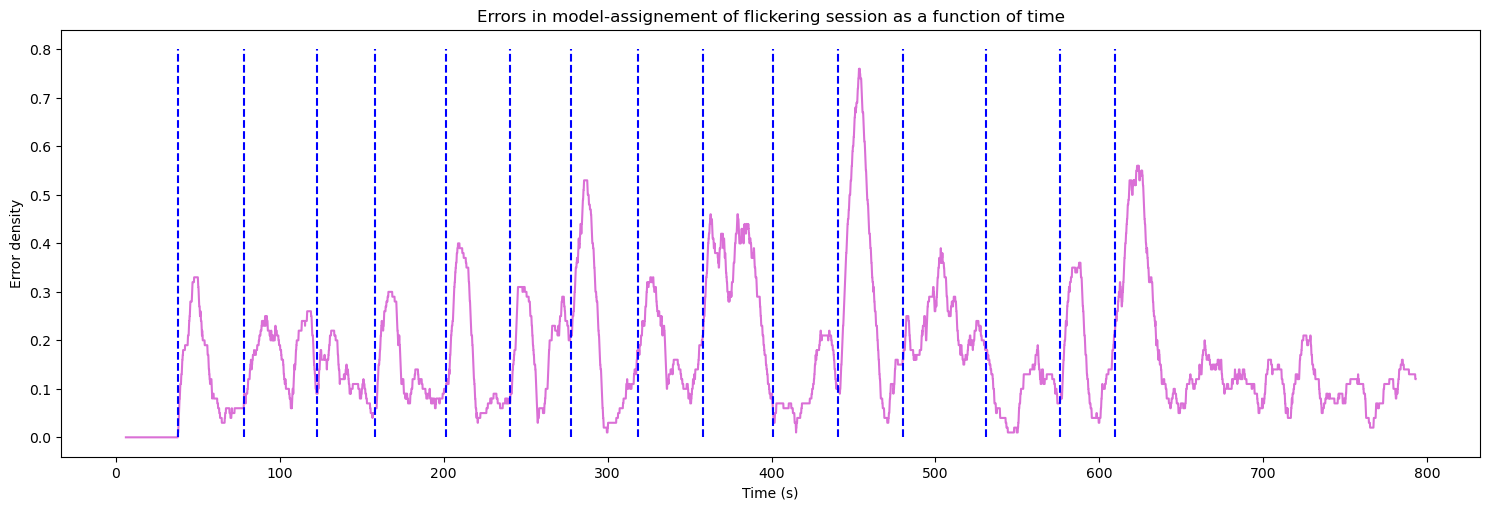

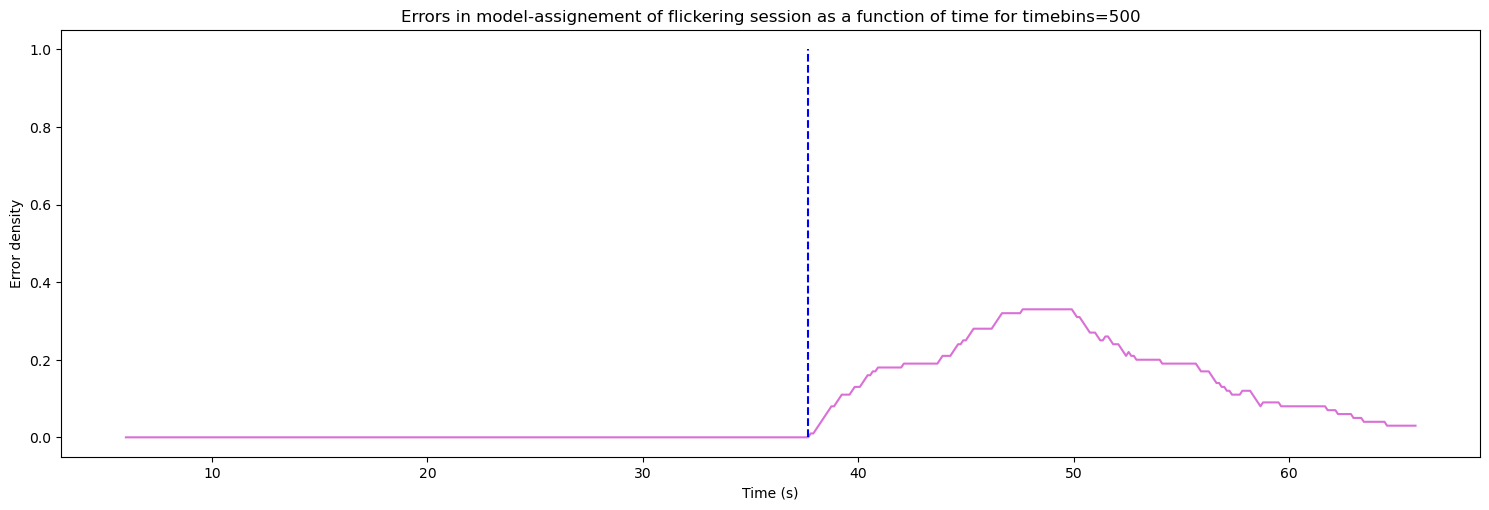

In [32]:
# Plot the smoothed data

#Redefine t_D
t_D_2 = t_D + 50*dt


plt.figure(figsize=(15, 5))
plt.plot(t_D_2, errors_arr_smoothed, color='orchid')
plt.vlines(teleportTimes, 0, 0.8, color='blue', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Error density')
plt.tight_layout()
plt.title("Errors in model-assignement of flickering session as a function of time")
plt.show()

# Plot the smoothed data for the 500 first time bins
plt.figure(figsize=(15, 5))
plt.plot(t_D_2[0:500], errors_arr_smoothed[0:500], color='orchid')
plt.vlines(teleportTimes[0], 0, 1, color='blue', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Error density')
plt.tight_layout()
plt.title("Errors in model-assignement of flickering session as a function of time for timebins=500")
plt.show()


- As depicted in the preceding graphs, decoding errors in identifying the correct environment tend to emerge slightly after the teleportation event. This occurrence arises from a brief period of time (less than a minute as seen in the second graph) during which both environment models can account for the spiking data observed during the flickering session. 